In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA

from validation.shared.validation_utils import read_pickle
from validation.shared.dataset_paths import real_set_path

%matplotlib inline

In [67]:
real_set_df = read_pickle(real_set_path)

In [68]:
real_set_df.sample(1)

,psptktno,sequence,loss,abnormal_yn,jaccard,euclidean,pc_sequence
52637,hamon20_20,"[1102, 1102, 502, 502, 502, 502, 502, 502, 502...",0.000005,False,0.85,1201.501144,"[4.625724298581545, 1.637490283412321, 2.19009..."


In [26]:
real_set_df.describe().T

,count,mean,std,min,25%,50%,75%,max
loss,64000.0,0.003923,0.011736,1.140378e-07,0.000002,0.000003,0.001106,0.063512
jaccard,64000.0,0.799722,0.186127,0.000000e+00,0.750000,0.850000,0.925000,1.000000
euclidean,64000.0,636.020143,649.228827,0.000000e+00,2.828427,597.000000,1200.501978,2876.979840


# Principle Component Analysis(PCA)
Principal Component Analysis (PCA) is a __linear dimensionality reduction technique__ that can be utilized for __extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space__. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

One important thing to note about PCA is that it is an Unsupervised dimensionality reduction technique, __you can cluster the similar data points based on the feature correlation between them without any supervision (or labels)__

- PCA is a statistical procedure that __uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables__ called principal components.

## PCA Use Case

- __Data Visualization:__ When working on any data related problem, the challenge in today's world is the sheer __volume of data__, and the variables/features that define that data. To solve a problem where data is the key, you need extensive __data exploration like finding out how the variables are correlated or understanding the distribution of a few variables.__ Considering that there are a large number of variables or dimensions along which the data is distributed, visualization can be a challenge and almost impossible.

## Data Visualization using PCA
Now comes the critical part, the next few lines of code will be projecting the fourty-dimensional sequence to two-dimensional & three-dimensional principal components.

In [81]:
legends = ['abnormal', 'normal']
labels = [True, False]

def loss(pca, sequence, inverse_sequence):
    data_loss = round((1 - np.sum(pca.explained_variance_ratio_)) * 100, 2)
    recovery_loss = np.mean(np.sum(np.square(sequence - inverse_sequence), axis = 1))
    
    return data_loss, recovery_loss

def plot_pca_2d_component(pca, sequence, inverse_sequence):
    
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    
    data_loss, recovery_loss = loss(pca, sequence, inverse_sequence)
    ax.set_title(f'data_loss: {data_loss}%, recovery_loss: {recovery_loss}', fontsize = 20)

    colors = ["blue", "red"]
    for label, color in zip(labels, colors):
        indices_to_keep = real_set_df['abnormal_yn'] == label
        
        pc_1 = np.array(real_set_df.loc[indices_to_keep, 'pc_sequence'].values.tolist())[:, 0]
        pc_2 = np.array(real_set_df.loc[indices_to_keep, 'pc_sequence'].values.tolist())[:, 1]
        
        ax.scatter(pc_1
                   ,pc_2
                   ,c = color
                   ,s = 30)

    ax.legend(legends)
    ax.grid()

    
def plot_pca_3d_component(pca, sequence, inverse_sequence):

    fig2 = plt.figure(figsize=(16,8))
    ax2 = fig2.add_subplot(111, projection='3d')

    ax2.set_xlabel('Principal Component 1', fontsize = 15)
    ax2.set_ylabel('Principal Component 2', fontsize = 15)
    ax2.set_zlabel('Principal Component 3', fontsize = 15)
    
    data_loss, recovery_loss = loss(pca, sequence, inverse_sequence)
    ax2.set_title(f'data_loss: {data_loss}%, recovery_loss: {recovery_loss}', fontsize = 20)

    colors = ["blue", "red"]
    for label, color in zip(labels, colors):
        indices_to_keep = real_set_df['abnormal_yn'] == label
        
        pc_1 = np.array(real_set_df.loc[indices_to_keep, 'pc_sequence'].values.tolist())[:, 0]
        pc_2 = np.array(real_set_df.loc[indices_to_keep, 'pc_sequence'].values.tolist())[:, 1]
        pc_3 = np.array(real_set_df.loc[indices_to_keep, 'pc_sequence'].values.tolist())[:, 2]
        
        ax2.scatter(pc_1
                   ,pc_2
                   ,pc_3
                   ,c = color
                   ,s = 30)

    ax2.legend(legends)
    ax2.grid()
    
def principle_components(n_components, is_plot = True):
    sequence = np.array(real_set_df.sequence.tolist())
    sequence = preprocessing.scale(sequence)
    
    pca = PCA(n_components = n_components)
    pc_sequence = pca.fit_transform(sequence)
    inverse_sequence = pca.inverse_transform(pc_sequence)
    
    if 'pc_sequence' in real_set_df.columns:
        real_set_df.drop(columns=['pc_sequence'], axis=1, inplace=True)
        
    real_set_df['pc_sequence'] = pc_sequence.tolist()
    
    if is_plot:
        if n_components == 2:
            plot_pca_2d_component(pca, sequence, inverse_sequence)
            
        elif n_components == 3:
            plot_pca_3d_component(pca, sequence, inverse_sequence)
        else:
            raise
        
        return None
    
    return loss(pca, sequence, inverse_sequence)
            

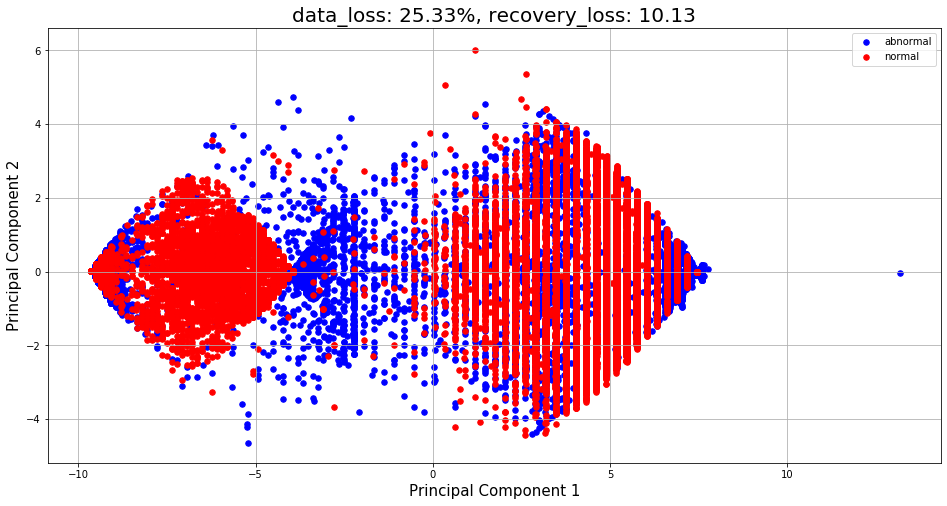

In [82]:
n_components = 2
principle_components(n_components=n_components)

In [30]:
pca_df = pd.DataFrame(
    np.array(real_set_df['pc_sequence'].values.tolist()), 
    columns=[f'pc{idx}' for idx in range(1, n_components + 1)]
)

pca_df['abnormal_yn'] = real_set_df['abnormal_yn'].values

In [31]:
pd.concat(
    [pca_df.loc[pca_df['abnormal_yn'] == False].describe().T,
     pca_df.loc[pca_df['abnormal_yn'] == True].describe().T], axis = 0
)

,count,mean,std,min,25%,50%,75%,max
pc1,47418.0,-0.193016,4.911775,-9.633005,-3.943883,-3.943405,4.893644,7.462868
pc2,47418.0,0.002158,1.105790,-4.442295,-0.207328,0.002863,0.173717,6.010560
pc1,16582.0,0.551950,6.439002,-9.539132,-3.898982,3.174559,6.895512,13.180487
pc2,16582.0,-0.006171,0.960243,-4.645516,-0.338530,-0.022272,0.290813,4.733399


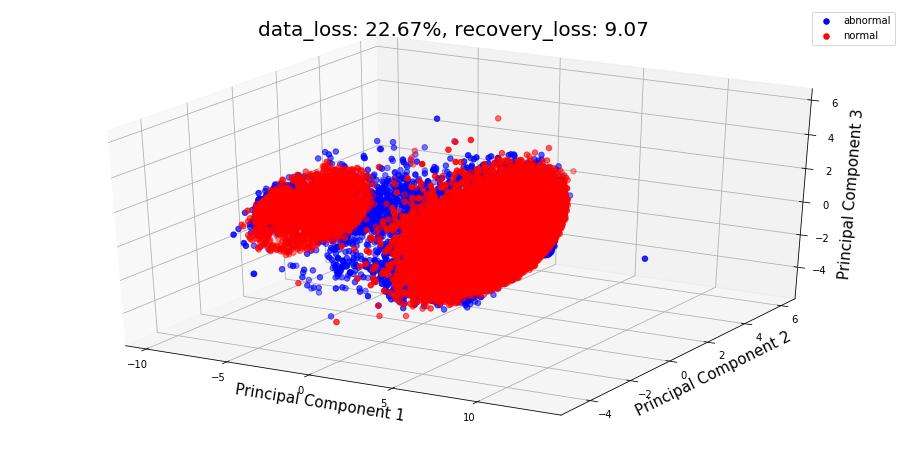

In [71]:
n_components = 3
principle_components(n_components=n_components)

In [33]:
pca_df = pd.DataFrame(
    np.array(real_set_df['pc_sequence'].values.tolist()), 
    columns=[f'pc{idx}' for idx in range(1, n_components + 1)]
)

pca_df['abnormal_yn'] = real_set_df['abnormal_yn'].values

In [34]:
pd.concat(
    [pca_df.loc[pca_df['abnormal_yn'] == False].describe().T,
     pca_df.loc[pca_df['abnormal_yn'] == True].describe().T], axis = 0
)

,count,mean,std,min,25%,50%,75%,max
pc1,47418.0,-0.193016,4.911775,-9.633005,-3.943883,-3.943405,4.893644,7.462868
pc2,47418.0,0.002158,1.105790,-4.442295,-0.207358,0.002863,0.173741,6.010524
pc3,47418.0,0.014313,1.051501,-5.175267,-0.188389,0.017764,0.178887,5.172705
pc1,16582.0,0.551950,6.439002,-9.539132,-3.898982,3.174559,6.895512,13.180487
pc2,16582.0,-0.006171,0.960244,-4.645541,-0.338542,-0.022273,0.290837,4.733412
pc3,16582.0,-0.040931,0.973737,-4.533977,-0.324748,-0.023024,0.247887,5.844843


## Optimal N components

Here, you can also __pass how much variance you want PCA to capture.__ Let's pass 0.9 as a parameter to the PCA model, which means that PCA will hold 90% of the variance and the number of components required to capture 90% variance will be used.

Note that earlier you passed n_components as a parameter and you could then find out how much variance was captured by those two components. __But here we explicitly mention how much variance we would like PCA to capture and hence, the n_components will vary based on the variance parameter.__

If you do not pass any variance, then the number of components will be equal to the original dimension of the data.

In [74]:
def optimize_pca_based_on_variance(variance_rate):
    sequence = np.array(real_set_df.sequence.tolist())
    sequence = preprocessing.scale(sequence)

    pca = PCA(variance_rate)
    pc_sequence = pca.fit_transform(sequence)
    inverse_sequence = pca.inverse_transform(pc_sequence)
    
    n_components = pca.n_components_
    data_loss, recovery_loss = loss(pca, sequence, inverse_sequence)
    
    print(f'optimal_n_components: {n_components}, data_loss: {data_loss}%, recovery_loss: {recovery_loss}%')
    
    return pca

optimal_n_components: 18, data_loss: 9.73%, recovery_loss: 3.89%


In [78]:
optimized_pca = optimize_pca_based_on_variance(0.99)

optimal_n_components: 37, data_loss: 0.84%, recovery_loss: 0.34%


In [97]:
loss_arr = np.array([principle_components(n_components = n, is_plot = False) for n in range(2, 38)])

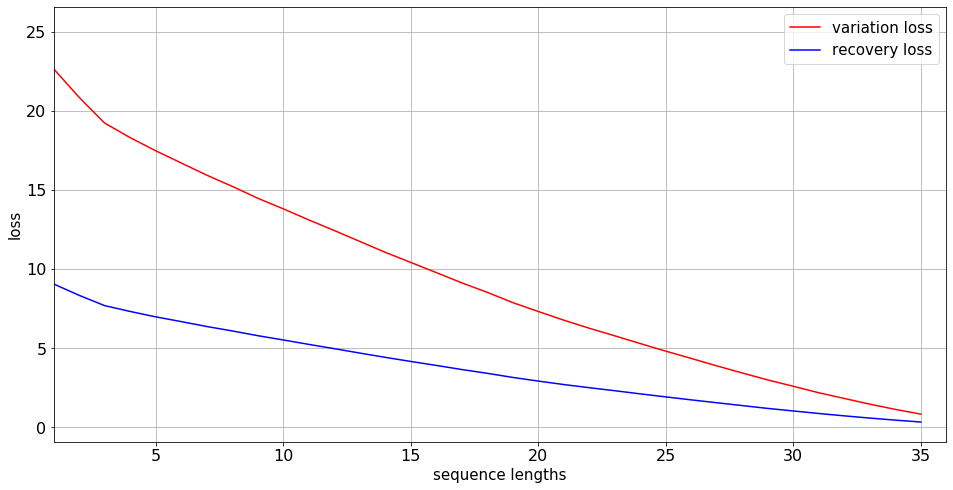

In [114]:
def plot_loss(arr):
    plt.figure(figsize=(16,8))
    
    plt.plot(arr[:, 0], c='red')
    plt.plot(arr[:, 1], c='blue')
    plt.legend(["variation loss","recovery loss"],fontsize=15)
    plt.grid(True)
    
    plt.xlim(1,36)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("sequence lengths", fontsize=15)
    plt.ylabel("loss",fontsize=15)
    
    plt.show()
    
plot_loss(loss_arr)

From the above output, you can observe that to achieve __90% variance__, __the dimension was reduced to 18 principal components from the actual 40 dimensions.__

Finally, you will apply transform on both the training and test set to generate a transformed dataset from the parameters generated from the fit method.

In [75]:
sequence = np.array(real_set_df.sequence.tolist())
sequence = preprocessing.scale(sequence)
sequence_pca = optimized_pca.transform(sequence)

In [76]:
sequence_pca

(64000, 18)